In [ ]:
!pip install -q --upgrade google-generativeai

In [ ]:
# Cell 1: basic imports
import pandas as pd
import numpy as np
import json
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import textwrap
import random
import google.generativeai as genai
import os
import re
import time
from typing import Optional
from google.colab import userdata

In [ ]:
# Cell 2: load keys and data
SECRET_NAMES = ["GEMINI_API_KEY1", "GEMINI_API_KEY2", "GEMINI_API_KEY3"]
keys = {}
missing = []
for name in SECRET_NAMES:
    k = userdata.get(name) if isinstance(userdata, dict) else os.getenv(name)
    if k:
        keys[name] = k
    else:
        missing.append(name)

print("Loaded keys:", list(keys.keys()))
if missing:
    print("Warning: missing keys (set them in Colab Secrets or provide):", missing)

Gemini successfully configured ✔️ (key hidden)


In [ ]:
api_key = userdata.get('GEMINI_API_KEY2')
if not api_key:
    raise ValueError("GEMINI_API_KEY not found. Set it in Colab's Secrets.")

genai.configure(api_key=api_key)
GEMINI_MODEL_NAME = "gemini-2.0-flash-lite"
print("Gemini successfully configured 2✔️ (key hidden)")

Gemini successfully configured 2✔️ (key hidden)


In [ ]:
api_key = userdata.get('GEMINI_API_KEY3')
if not api_key:
    raise ValueError("GEMINI_API_KEY not found. Set it in Colab's Secrets.")

genai.configure(api_key=api_key)
GEMINI_MODEL_NAME = "gemini-2.0-flash-lite"
print("Gemini successfully configured 3✔️ (key hidden)")

Gemini successfully configured 3✔️ (key hidden)


In [ ]:
DATA_PATH = "/content/yelp.csv"
df = pd.read_csv(DATA_PATH)
df[['text', 'stars']].head()

,text,stars
0,My wife took me here on my birthday for breakf...,5
1,I have no idea why some people give bad review...,5
2,love the gyro plate. Rice is so good and I als...,4
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5
4,General Manager Scott Petello is a good egg!!!...,5


In [ ]:
# Cell 3: stratified sample of 200 reviews
def stratified_sample(df, label_col='stars', n_total=200, random_state=42):
    random.seed(random_state)
    np.random.seed(random_state)

    labels = df[label_col].unique()
    labels = sorted(labels)
    per_class = max(1, n_total // len(labels))
    samples = []

    for label in labels:
        subset = df[df[label_col] == label]
        if len(subset) <= per_class:
            samples.append(subset)
        else:
            samples.append(subset.sample(per_class, random_state=random_state))

    sampled_df = pd.concat(samples).sample(frac=1, random_state=random_state).reset_index(drop=True)
    return sampled_df

eval_df = stratified_sample(df, label_col='stars', n_total=200)
eval_df.shape, eval_df['stars'].value_counts()

((200, 10),
 stars
 3    40
 1    40
 4    40
 2    40
 5    40
 Name: count, dtype: int64)

In [ ]:
# Cell 4: LLM client wrapper - Gemini 2.5 Flash + safety handling
class LLMClient:
    def __init__(self,
                 api_key: Optional[str] = None,
                 model_name: str | None = None,
                 temperature: float = 0.2,
                 max_output_tokens: int = 512,
                 max_retries: int = 6,
                 base_delay: float = 1.0):
        if api_key:
            genai.configure(api_key=api_key)
        self.model_name = model_name or globals().get("GEMINI_MODEL_NAME", None)
        if not self.model_name:
            raise ValueError("model_name must be provided either as GEMINI_MODEL_NAME or to LLMClient.")
        self.temperature = temperature
        self.max_output_tokens = max_output_tokens
        self.max_retries = max_retries
        self.base_delay = base_delay
        self._model = genai.GenerativeModel(self.model_name)

    def _dummy_json(self, explanation: str) -> str:
        explanation = explanation.replace('"', "'")
        return json.dumps({"predicted_stars": None, "explanation": explanation})

    def _parse_retry_seconds(self, exc: Exception) -> Optional[float]:
        try:
            msg = str(exc)
            m = re.search(r"retry in ([0-9]+(?:\.[0-9]+)?)s", msg, re.IGNORECASE)
            if m:
                return float(m.group(1))
            m2 = re.search(r"Retry-After:\s*([0-9]+)", msg, re.IGNORECASE)
            if m2:
                return float(m2.group(1))
        except Exception:
            return None
        return None

    def call_model(self, prompt: str) -> str:
        last_error: Optional[Exception] = None

        for attempt in range(self.max_retries):
            try:
                response = self._model.generate_content(
                    prompt,
                    generation_config=genai.types.GenerationConfig(
                        temperature=self.temperature,
                        max_output_tokens=self.max_output_tokens,
                    ),
                )

                try:
                    text = getattr(response, "text", None)
                except ValueError:
                    return self._dummy_json("Safety filters blocked this content; no rating produced.")

                if not text:
                    text = ""
                    if hasattr(response, "candidates") and response.candidates:
                        parts = []
                        for cand in response.candidates:
                            content = getattr(cand, "content", None)
                            if content is not None and getattr(content, "parts", None):
                                for p in content.parts:
                                    if hasattr(p, "text"):
                                        parts.append(p.text)
                        text = "\n".join(parts).strip()

                if not text:
                    return self._dummy_json("No usable text returned by the model.")

                return text.strip()

            except Exception as e:
                last_error = e
                retry_seconds = self._parse_retry_seconds(e)
                wait = self.base_delay * (2 ** attempt)
                if retry_seconds is not None:
                    wait = max(wait, retry_seconds)
                if attempt == self.max_retries - 1:
                    msg = str(e)
                    if "429" in msg or "TooManyRequests" in msg or "quota" in msg.lower():
                        return self._dummy_json("Rate limit reached; no rating produced for this review.")
                    return self._dummy_json(f"Error calling model: {type(e).__name__}")
                time.sleep(wait)

        return self._dummy_json("Unknown error calling model.")

In [ ]:
# Cell 5: Prompt template - Approach 1 (Baseline Direct)
BASELINE_SYSTEM_INSTRUCTIONS = textwrap.dedent("""
You are an assistant that rates customer reviews for businesses on a 1 to 5 star scale.

Use the following guidelines:
- 1 star: Extremely negative experience, strong dissatisfaction, major issues.
- 2 stars: Mostly negative experience, multiple issues, would probably not return.
- 3 stars: Mixed or neutral, both positives and negatives, might or might not return.
- 4 stars: Mostly positive experience, minor issues at most.
- 5 stars: Very positive experience, highly satisfied, would strongly recommend.

Your task:
Given a single customer review, decide the most appropriate star rating from 1 to 5.

You must output ONLY valid JSON in the following format:
{
  "predicted_stars": <an integer from 1 to 5>,
  "explanation": "<a short explanation of why you chose this rating>"
}
Do not include any other keys or text.
""").strip()


def build_prompt_approach_1(review_text: str) -> str:
    return f"""{BASELINE_SYSTEM_INSTRUCTIONS}

Review:
\"\"\"{review_text}\"\"\"

Now respond with the JSON object.
"""

In [ ]:
# Cell 6: Prompt template - Approach 2 (Few-shot)
FEWSHOT_INSTRUCTIONS = textwrap.dedent("""
You are an assistant that rates customer reviews for businesses on a 1 to 5 star scale.

Rating rubric:
- 1 star: Extremely negative, serious problems, user clearly unhappy.
- 2 stars: Negative overall, some redeeming qualities but still poor experience.
- 3 stars: Mixed/neutral, clear pros and cons, average experience.
- 4 stars: Generally positive with minor issues, user would likely return.
- 5 stars: Very positive, enthusiastic, strongly recommends.

Read the review carefully and choose the rating that best matches the overall tone and content.

You MUST respond ONLY with JSON in this exact format:
{
  "predicted_stars": <integer 1 to 5>,
  "explanation": "<short one-sentence explanation>"
}
""").strip()

FEWSHOT_EXAMPLES = textwrap.dedent("""
Example 1:
Review:
"I waited 40 minutes for my food, and when it finally came it was cold and tasteless. The staff didn't seem to care at all."
Expected JSON:
{
  "predicted_stars": 1,
  "explanation": "Very negative experience with long wait, bad food, and poor service."
}

Example 2:
Review:
"The food was pretty good and the portions were large, but the service was a bit slow and the place was noisy."
Expected JSON:
{
  "predicted_stars": 3,
  "explanation": "Mixed review with good food but issues with service speed and noise."
}

Example 3:
Review:
"Absolutely loved this place! The staff were friendly, the food was excellent, and I'll definitely be coming back."
Expected JSON:
{
  "predicted_stars": 5,
  "explanation": "Very positive review praising staff, food, and intent to return."
}
""").strip()


def build_prompt_approach_2(review_text: str) -> str:
    return f"""{FEWSHOT_INSTRUCTIONS}

{FEWSHOT_EXAMPLES}

Now classify the following review using the same JSON format.

Review:
\"\"\"{review_text}\"\"\"

JSON:
"""

In [ ]:
# Cell 7: Prompt template - Approach 3 (Reason-then-rate, strict JSON)
STRICT_INSTRUCTIONS = textwrap.dedent("""
You are an assistant that rates customer reviews for businesses on a 1 to 5 star scale.

First, silently think through:
- What aspects of the experience are mentioned? (e.g., food, service, price, ambiance)
- Are those aspects described positively, negatively, or mixed?
- How intense is the sentiment?

Then, based on your reasoning, choose a rating using this rubric:
- 1 star: Extremely negative, serious problems, clearly unhappy.
- 2 stars: Mostly negative overall, multiple issues.
- 3 stars: Mixed/neutral, clear pros and cons.
- 4 stars: Mostly positive, minor issues at most.
- 5 stars: Very positive, enthusiastic, highly satisfied.

Important:
- DO NOT show your reasoning.
- ONLY output a single JSON object with this exact schema:

{
  "predicted_stars": <integer from 1 to 5>,
  "explanation": "<short single-line explanation without line breaks>"
}

Rules:
- "predicted_stars" must be an integer 1, 2, 3, 4, or 5.
- "explanation" must be a short single-line text under 30 words.
- Do not include any extra text before or after the JSON.
""").strip()


def build_prompt_approach_3(review_text: str) -> str:
    return f"""{STRICT_INSTRUCTIONS}

Review:
\"\"\"{review_text}\"\"\"

JSON:
"""

In [ ]:
# Cell 8: JSON parsing helper
def parse_llm_json_output(output: str):
    if not isinstance(output, str):
        return None, False

    cleaned = output.strip()

    if cleaned.startswith("```"):
        cleaned = cleaned.strip("`").strip()
        if cleaned.lower().startswith("json"):
            cleaned = cleaned[4:].strip()

    first_brace = cleaned.find("{")
    last_brace = cleaned.rfind("}")
    if first_brace != -1 and last_brace != -1 and last_brace > first_brace:
        cleaned = cleaned[first_brace:last_brace + 1]

    try:
        data = json.loads(cleaned)
        return data, True
    except Exception:
        return None, False

In [ ]:
# Cell 9: single prediction
def predict_rating_for_review(review_text: str, build_prompt_fn, llm_client: LLMClient):
    prompt = build_prompt_fn(review_text)
    raw_output = llm_client.call_model(prompt)
    parsed, is_valid = parse_llm_json_output(raw_output)

    result = {
        "raw_output": raw_output,
        "parsed": parsed,
        "json_valid": is_valid
    }

    if is_valid:
        try:
            stars = int(parsed.get("predicted_stars", None))
        except Exception:
            stars = None
        explanation = parsed.get("explanation", None)
    else:
        stars, explanation = None, None

    result["predicted_stars"] = stars
    result["explanation"] = explanation
    return result

In [ ]:
# Cell 10: run_evaluation
def run_evaluation(eval_df,
                   build_prompt_fn,
                   llm_client: Optional[LLMClient] = None,
                   api_key: Optional[str] = None,
                   model_name: Optional[str] = None,
                   approach_name: str = "approach",
                   out_csv: str = "results_tmp.csv",
                   start_index: int = 0,
                   max_rows: int | None = None,
                   per_request_delay: float = 3.0,
                   batch_size: int = 50,
                   batch_pause_seconds: float = 60.0,
                   save_every: int = 10):
    created_client = False
    if llm_client is None:
        if api_key is None:
            raise ValueError("Either llm_client or api_key must be provided.")
        llm_client = LLMClient(api_key=api_key, model_name=model_name)
        created_client = True

    records = []
    rows = eval_df if max_rows is None else eval_df.head(max_rows)
    total = len(rows)
    print(f"Starting evaluation for approach='{approach_name}' rows={total} from start_index={start_index}")
    processed = 0

    if os.path.exists(out_csv) and start_index == 0:
        try:
            prev = pd.read_csv(out_csv)
            if not prev.empty and "approach" in prev.columns:
                prev_same = prev[prev["approach"] == approach_name]
                if not prev_same.empty:
                    last_idx = int(prev_same["review_id"].max())
                    print(f"Resuming from previously saved file; last processed review_id={last_idx}")
                    start_index = last_idx + 1
        except Exception:
            start_index = 0

    for idx in range(start_index, total):
        row = rows.iloc[idx]
        review_text = row['text']
        true_stars = int(row['stars'])

        prompt = build_prompt_fn(review_text)
        raw_output = llm_client.call_model(prompt)
        parsed, json_valid = parse_llm_json_output(raw_output)
        predicted_stars = None
        explanation = None
        if json_valid and parsed is not None:
            try:
                predicted_stars = parsed.get("predicted_stars", None)
                explanation = parsed.get("explanation", None)
            except Exception:
                predicted_stars = None
                explanation = None

        rec = {
            "review_id": idx,
            "review_text": review_text,
            "true_stars": true_stars,
            "predicted_stars": predicted_stars,
            "explanation": explanation,
            "json_valid": json_valid,
            "raw_output": raw_output.replace("\n", "\\n") if isinstance(raw_output, str) else raw_output,
            "approach": approach_name,
            "timestamp": time.time()
        }
        records.append(rec)
        processed += 1

        if (processed % save_every) == 0 or (idx == total - 1):
            df_new = pd.DataFrame(records)
            if os.path.exists(out_csv):
                try:
                    prev = pd.read_csv(out_csv)
                    combined = pd.concat([prev, df_new], ignore_index=True)
                    combined.to_csv(out_csv, index=False)
                except Exception:
                    df_new.to_csv(out_csv, index=False)
            else:
                df_new.to_csv(out_csv, index=False)
            print(f"Saved progress: processed {processed} rows -> {out_csv}")
            records = []

        time.sleep(per_request_delay)
        if (processed % batch_size) == 0 and processed > 0:
            print(f"Completed batch of {batch_size}. Pausing for {batch_pause_seconds}s to avoid burst limits.")
            time.sleep(batch_pause_seconds)

    print("Evaluation finished.")
    if os.path.exists(out_csv):
        return pd.read_csv(out_csv)
    else:
        return pd.DataFrame(records)

In [ ]:
# Cell 11: metrics helper
def compute_metrics(results_df):
    valid_mask = results_df['predicted_stars'].notnull()
    valid_df = results_df[valid_mask].copy()

    json_valid_rate = results_df['json_valid'].mean()

    if len(valid_df) == 0:
        return {
            "accuracy": None,
            "mae": None,
            "json_valid_rate": json_valid_rate,
            "n_total": len(results_df),
            "n_valid_preds": 0
        }

    y_true = valid_df['true_stars'].astype(int).values
    y_pred = valid_df['predicted_stars'].astype(int).values

    accuracy = (y_true == y_pred).mean()
    mae = np.mean(np.abs(y_true - y_pred))

    return {
        "accuracy": accuracy,
        "mae": mae,
        "json_valid_rate": json_valid_rate,
        "n_total": len(results_df),
        "n_valid_preds": len(valid_df)
    }

In [ ]:
# Cell 12: confusion matrix plotting
def plot_confusion_matrix(results_df, title="Confusion Matrix"):
    valid_df = results_df[results_df['predicted_stars'].notnull()].copy()
    if valid_df.empty:
        print("No valid predictions to plot.")
        return

    y_true = valid_df['true_stars'].astype(int).values
    y_pred = valid_df['predicted_stars'].astype(int).values

    labels = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, cm[i, j], ha='center', va='center')

    plt.colorbar(im)
    plt.show()

In [ ]:
# Cell 13: run all approaches
results_1 = run_evaluation(
    eval_df,
    build_prompt_approach_1,
    api_key=keys.get("GEMINI_API_KEY1"),
    model_name="gemini-2.0-flash-lite",
    approach_name="approach_1_baseline",
    out_csv="results_approach_1.csv",
    max_rows=200,
    per_request_delay=3.0,
    batch_size=50,
    batch_pause_seconds=60.0,
    save_every=10
)

Starting evaluation for approach='approach_1_baseline' rows=200 from start_index=0
Saved progress: processed 10 rows -> results_approach_1.csv
Saved progress: processed 20 rows -> results_approach_1.csv
Saved progress: processed 30 rows -> results_approach_1.csv
Saved progress: processed 40 rows -> results_approach_1.csv
Saved progress: processed 50 rows -> results_approach_1.csv
Completed batch of 50. Pausing for 60.0s to avoid burst limits.
Saved progress: processed 60 rows -> results_approach_1.csv
Saved progress: processed 70 rows -> results_approach_1.csv
Saved progress: processed 80 rows -> results_approach_1.csv
Saved progress: processed 90 rows -> results_approach_1.csv
Saved progress: processed 100 rows -> results_approach_1.csv
Completed batch of 50. Pausing for 60.0s to avoid burst limits.
Saved progress: processed 110 rows -> results_approach_1.csv
Saved progress: processed 120 rows -> results_approach_1.csv
Saved progress: processed 130 rows -> results_approach_1.csv
Saved

In [ ]:
results_2 = run_evaluation(
    eval_df,
    build_prompt_approach_2,
    api_key=keys.get("GEMINI_API_KEY2"),
    model_name="gemini-2.0-flash-lite",
    approach_name="approach_2_fewshot",
    out_csv="results_approach_2.csv",
    max_rows=200,
    per_request_delay=3.0,
    batch_size=50,
    batch_pause_seconds=60.0,
    save_every=10
)

Starting evaluation for approach='approach_2_fewshot' rows=200 from start_index=0
Saved progress: processed 10 rows -> results_approach_2.csv
Saved progress: processed 20 rows -> results_approach_2.csv
Saved progress: processed 30 rows -> results_approach_2.csv
Saved progress: processed 40 rows -> results_approach_2.csv
Saved progress: processed 50 rows -> results_approach_2.csv
Completed batch of 50. Pausing for 60.0s to avoid burst limits.
Saved progress: processed 60 rows -> results_approach_2.csv
Saved progress: processed 70 rows -> results_approach_2.csv
Saved progress: processed 80 rows -> results_approach_2.csv
Saved progress: processed 90 rows -> results_approach_2.csv
Saved progress: processed 100 rows -> results_approach_2.csv
Completed batch of 50. Pausing for 60.0s to avoid burst limits.
Saved progress: processed 110 rows -> results_approach_2.csv
Saved progress: processed 120 rows -> results_approach_2.csv
Saved progress: processed 130 rows -> results_approach_2.csv
Saved 

Saved progress: processed 160 rows -> results_approach_2.csv


Saved progress: processed 170 rows -> results_approach_2.csv
Saved progress: processed 180 rows -> results_approach_2.csv


Saved progress: processed 190 rows -> results_approach_2.csv


/tmp/ipython-input-4034695047.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([prev, df_new], ignore_index=True)


Saved progress: processed 200 rows -> results_approach_2.csv
Completed batch of 50. Pausing for 60.0s to avoid burst limits.
Evaluation finished.


In [ ]:
results_3 = run_evaluation(
    eval_df,
    build_prompt_approach_3,
    api_key=keys.get("GEMINI_API_KEY3"),
    model_name="gemini-2.0-flash-lite",
    approach_name="approach_3_reason_then_rate",
    out_csv="results_approach_3.csv",
    max_rows=200,
    per_request_delay=3.0,
    batch_size=50,
    batch_pause_seconds=60.0,
    save_every=10
)

Starting evaluation for approach='approach_3_strict' rows=200 from start_index=0
Saved progress: processed 10 rows -> results_approach_3.csv
Saved progress: processed 20 rows -> results_approach_3.csv
Saved progress: processed 30 rows -> results_approach_3.csv
Saved progress: processed 40 rows -> results_approach_3.csv
Saved progress: processed 50 rows -> results_approach_3.csv
Completed batch of 50. Pausing for 60.0s to avoid burst limits.
Saved progress: processed 60 rows -> results_approach_3.csv


Saved progress: processed 70 rows -> results_approach_3.csv
Saved progress: processed 80 rows -> results_approach_3.csv
Saved progress: processed 90 rows -> results_approach_3.csv
Saved progress: processed 100 rows -> results_approach_3.csv
Completed batch of 50. Pausing for 60.0s to avoid burst limits.
Saved progress: processed 110 rows -> results_approach_3.csv
Saved progress: processed 120 rows -> results_approach_3.csv
Saved progress: processed 130 rows -> results_approach_3.csv
Saved progress: processed 140 rows -> results_approach_3.csv
Saved progress: processed 150 rows -> results_approach_3.csv
Completed batch of 50. Pausing for 60.0s to avoid burst limits.
Saved progress: processed 160 rows -> results_approach_3.csv
Saved progress: processed 170 rows -> results_approach_3.csv
Saved progress: processed 180 rows -> results_approach_3.csv
Saved progress: processed 190 rows -> results_approach_3.csv
Saved progress: processed 200 rows -> results_approach_3.csv
Completed batch of 50

In [ ]:
# Cell 14: compare metrics
metrics_1 = compute_metrics(results_1)
metrics_2 = compute_metrics(results_2)
metrics_3 = compute_metrics(results_3)

comparison_df = pd.DataFrame([
    {"approach": "baseline_direct", **metrics_1},
    {"approach": "fewshot_rubric", **metrics_2},
    {"approach": "reason_then_rate_strict", **metrics_3},
])
comparison_df

,approach,accuracy,mae,json_valid_rate,n_total,n_valid_preds
0,baseline_direct,0.670000,0.355000,1.0,200,200
1,fewshot_rubric,0.731183,0.290323,1.0,200,186
2,reason_then_rate_strict,0.665000,0.370000,1.0,200,200


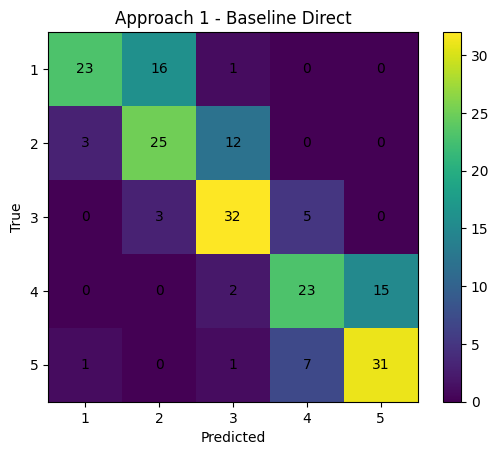

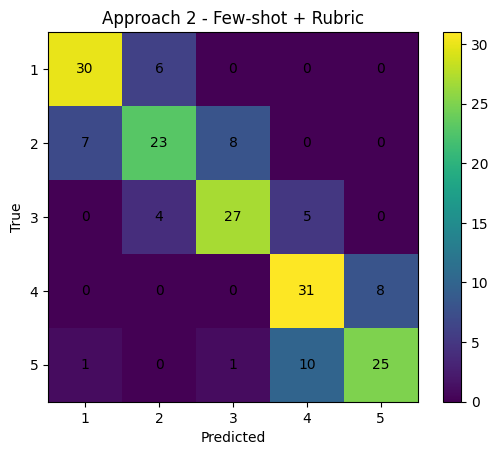

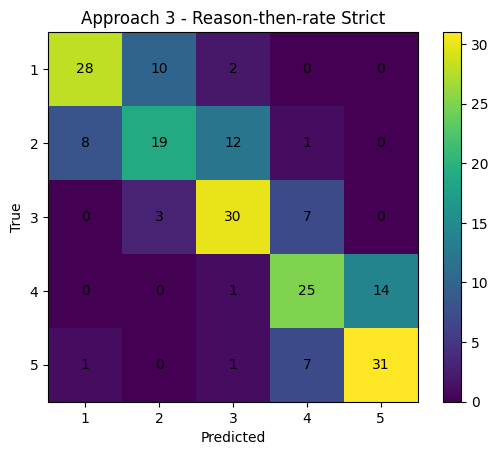

In [ ]:
# Cell 15: confusion matrices per approach
plot_confusion_matrix(results_1, title="Approach 1 - Baseline Direct")
plot_confusion_matrix(results_2, title="Approach 2 - Few-shot + Rubric")
plot_confusion_matrix(results_3, title="Approach 3 - Reason-then-rate Strict")